<a href="https://colab.research.google.com/github/Narennnnn/EmoNet-Deep-Learning-for-Facial-Expression-Recognition/blob/main/FacialExpressionDetectionMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import h5py


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
ls


drive/  sample_data/


In [7]:
%cd drive/MyDrive/Facial\ Expression\ Dataset/

/content/drive/MyDrive/Facial Expression Dataset


In [8]:
!unzip Dataset.zip

Archive:  Dataset.zip
replace fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fer2013.csv             y

replace fer2013/fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: fer2013/fer2013.csv     


In [9]:
import pandas as pd

csv_path = '/content/drive/MyDrive/Facial Expression Dataset/fer2013.csv'
data = pd.read_csv(csv_path)

image_paths = data['pixels'].values
labels = data['emotion'].values


In [10]:
# Process the image paths
preprocessed_images = []
for image_data in image_paths:
    image = np.array(image_data.split(' '), dtype=np.uint8)
    image = image.reshape((48, 48))
    preprocessed_images.append(image)


In [11]:
# Convert the preprocessed data to NumPy arrays
preprocessed_images = np.array(preprocessed_images)
labels = np.array(labels)


In [12]:
# Data augmentation using ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
# Generate augmented images and labels
augmented_images = []
augmented_labels = []
for image, label in zip(preprocessed_images, labels):
    image = np.expand_dims(image, axis=-1)  # Add an additional dimension for the channel
    image = np.expand_dims(image, axis=0)  # Add an additional dimension for the batch
    aug_iter = datagen.flow(image, save_to_dir=None, shuffle=False)
    for aug_image in aug_iter:
        augmented_images.append(aug_image[0])
        augmented_labels.append(label)
        break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [14]:
# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [15]:
# Build the deep learning model
num_classes = len(np.unique(labels))
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))


Epoch 1/20
718/718 [==============================] - 274s 378ms/step - loss: 1.9392 - accuracy: 0.2779 - val_loss: 1.7072 - val_accuracy: 0.3217
Epoch 2/20
718/718 [==============================] - 271s 377ms/step - loss: 1.6686 - accuracy: 0.3380 - val_loss: 1.6180 - val_accuracy: 0.3708
Epoch 3/20
718/718 [==============================] - 279s 388ms/step - loss: 1.5858 - accuracy: 0.3828 - val_loss: 1.5948 - val_accuracy: 0.3716
Epoch 4/20
718/718 [==============================] - 275s 383ms/step - loss: 1.5082 - accuracy: 0.4150 - val_loss: 1.5303 - val_accuracy: 0.4121
Epoch 5/20
718/718 [==============================] - 275s 383ms/step - loss: 1.4258 - accuracy: 0.4510 - val_loss: 1.5140 - val_accuracy: 0.4267
Epoch 6/20
718/718 [==============================] - 273s 381ms/step - loss: 1.3404 - accuracy: 0.4887 - val_loss: 1.4747 - val_accuracy: 0.4305
Epoch 7/20
718/718 [==============================] - 268s 374ms/step - loss: 1.2346 - accuracy: 0.5317 - val_loss: 1.4847 -

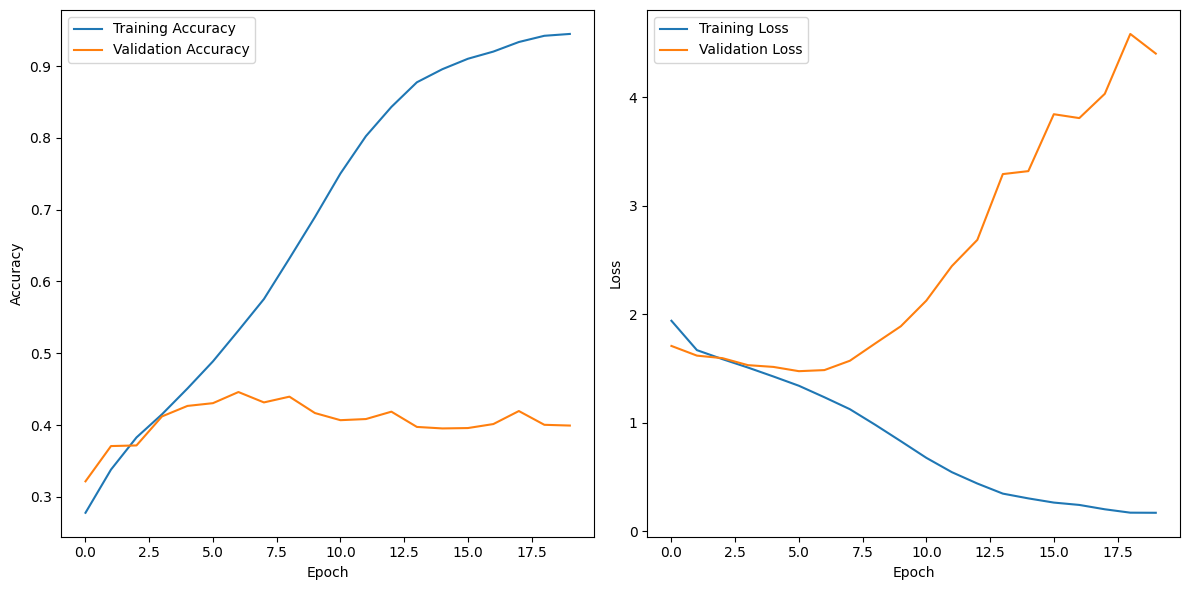

225/225 [==============================] - 20s 89ms/step - loss: 4.5497 - accuracy: 0.3891
Test Loss: 4.549702167510986
Test Accuracy: 0.38910558819770813


In [17]:

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 6))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

In [18]:
# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

225/225 [==============================] - 20s 90ms/step


In [19]:
# Generate classification report
target_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Angry       0.32      0.23      0.27       985
     Disgust       0.10      0.09      0.09       102
        Fear       0.23      0.27      0.25      1043
       Happy       0.60      0.60      0.60      1765
         Sad       0.30      0.30      0.30      1210
    Surprise       0.53      0.43      0.48       795
     Neutral       0.34      0.40      0.37      1278

    accuracy                           0.39      7178
   macro avg       0.34      0.33      0.34      7178
weighted avg       0.39      0.39      0.39      7178



In [20]:
# Save the model in HDF5 format
model.save('/content/drive/MyDrive/model.h5')